In [28]:
# First of all, we need to import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
import time
from scipy.stats import norm
from sklearn.metrics import mean_absolute_percentage_error

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [29]:
# Load the dataset
data = pd.read_csv('data/input/sample.csv')

# Display the first 5 rows
data.head()

APPOINTMENT_CREATION_DATE CONTAINER_SERVICE_PRICE
0       24/02/2024 13:15:16                    1169
1       23/02/2024 14:45:28                     899
2       23/02/2024 14:45:39                     899
3            3/4/2024 12:25                     899
4       25/03/2024 12:12:30                    1169

In [30]:
## Date format correction

# Function to correct the date format and add seconds if necessary
def fix_date_format(date_str):
    # Regular expression to find dates with single-digit days and months
    date_pattern = r"(\d{1,2})/(\d{1,2})/(\d{4}) (\d{1,2}):(\d{1,2})(?::(\d{1,2}))?"
    
    # Fix days/months without leading zeros and add seconds if missing
    if re.match(date_pattern, date_str):
        # Add leading zeros to days and months if necessary, and add seconds if missing
        return re.sub(date_pattern, lambda m: f"{int(m.group(1)):02d}/{int(m.group(2)):02d}/{m.group(3)} {int(m.group(4)):02d}:{int(m.group(5)):02d}:{m.group(6) if m.group(6) else '00'}", date_str)
    
    return date_str

# Apply the function to the date column
data['APPOINTMENT_CREATION_DATE'] = data['APPOINTMENT_CREATION_DATE'].apply(fix_date_format)

# Save the corrected data
data.to_csv('sample_corrected.csv', index=False)

# Load the corrected dataset
data = pd.read_csv('data/output/sample_corrected.csv')

data

APPOINTMENT_CREATION_DATE CONTAINER_SERVICE_PRICE
0            24/02/2024 13:15:16                    1169
1            23/02/2024 14:45:28                     899
2            23/02/2024 14:45:39                     899
3            03/04/2024 12:25:00                     899
4            25/03/2024 12:12:30                    1169
...                          ...                     ...
225275       31/07/2024 14:52:29                     NaN
225276       31/07/2024 17:34:16                     NaN
225277       30/07/2024 10:49:05                     NaN
225278       31/07/2024 16:35:28                     NaN
225279       31/07/2024 12:59:28                     NaN

[225280 rows x 2 columns]

In [31]:
# View dataset information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225280 entries, 0 to 225279
Data columns (total 2 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   APPOINTMENT_CREATION_DATE  225280 non-null  object
 1   CONTAINER_SERVICE_PRICE    17041 non-null   object
dtypes: object(2)
memory usage: 3.4+ MB


In [32]:
# View unique values in the column
print(data["CONTAINER_SERVICE_PRICE"].unique())

['1169' '899' '1015.87' nan '699' '803.85' '410' 'boorra' '1168.25']


In [33]:
# Remove records that cannot be cast to numeric
data = data[~data["CONTAINER_SERVICE_PRICE"].str.contains("[a-zA-Z]", na=False)]

# Convert the column to numeric
data["CONTAINER_SERVICE_PRICE"] = pd.to_numeric(data["CONTAINER_SERVICE_PRICE"])

# Convert the APPOINTMENT_CREATION_DATE column to datetime type
data['APPOINTMENT_CREATION_DATE'] = pd.to_datetime(data['APPOINTMENT_CREATION_DATE'], dayfirst=True, errors='coerce')

In [34]:
# Check the first 5 rows of the data to understand its structure
print(data.head())

  APPOINTMENT_CREATION_DATE  CONTAINER_SERVICE_PRICE
0       2024-02-24 13:15:16                   1169.0
1       2024-02-23 14:45:28                    899.0
2       2024-02-23 14:45:39                    899.0
3       2024-04-03 12:25:00                    899.0
4       2024-03-25 12:12:30                   1169.0


In [35]:
# check the overall information of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 225279 entries, 0 to 225279
Data columns (total 2 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   APPOINTMENT_CREATION_DATE  225279 non-null  datetime64[ns]
 1   CONTAINER_SERVICE_PRICE    17040 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 5.2 MB


In [36]:
# Data augmentation for analysis

# Extract the month from the APPOINTMENT_CREATION_DATE
data['month'] = data['APPOINTMENT_CREATION_DATE'].dt.month

# Extract the year from the APPOINTMENT_CREATION_DATE
data['year'] = data['APPOINTMENT_CREATION_DATE'].dt.year

# Extract the day from the APPOINTMENT_CREATION_DATE
data['day'] = data['APPOINTMENT_CREATION_DATE'].dt.day

In [37]:
# Define a copy of the dataframe without null values
data_no_nulls = data.dropna()


In [38]:
# Bar chart for the number of records per month in APPOINTMENT_CREATION_DATE

# Get the number of records per month and year
data_grouped = data.groupby(['year', 'month']).size().reset_index(name='count')
data_nonull_grouped = data_no_nulls.groupby(['year', 'month']).size().reset_index(name='count')

# Plot the number of records per month and year as a bar chart for each dataset
plt.figure(figsize=(15, 5))

# Get the maximum Y-axis limits for both charts
y_max = max(data_grouped['count'].max(), data_nonull_grouped['count'].max())

# Plot the bar chart for the dataset with null values
plt.subplot(1, 2, 1)
sns.barplot(data=data_grouped, x='month', y='count', hue='year', palette='dark:Blue')
plt.ylim(0, y_max)  # Set the same limit for the Y-axis
plt.title('Records per Month and Year')

# Plot the bar chart for the dataset without null values
plt.subplot(1, 2, 2)
sns.barplot(data=data_nonull_grouped, x='month', y='count', hue='year', palette='dark:Blue')
plt.ylim(0, y_max)  # Set the same limit for the Y-axis
plt.title('Records per Month and Year (No Nulls)')

plt.tight_layout()
plt.show()


In [39]:
# Take the data without nulls as the main dataset
data = data_no_nulls.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17040 entries, 0 to 225263
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   APPOINTMENT_CREATION_DATE  17040 non-null  datetime64[ns]
 1   CONTAINER_SERVICE_PRICE    17040 non-null  float64       
 2   month                      17040 non-null  int32         
 3   year                       17040 non-null  int32         
 4   day                        17040 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(3)
memory usage: 599.1 KB


In [40]:
# Next, the data will be treated as a time series
data.set_index('APPOINTMENT_CREATION_DATE', inplace=True)

# Drop columns that won't be used
data.drop(['month', 'year', 'day'], axis=1, inplace=True)

# Group the dataset by day, calculating the daily mean of CONTAINER_SERVICE_PRICE
data = data.groupby(data.index.date)['CONTAINER_SERVICE_PRICE'].mean()

# Generate a date range for the dataset
date_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')

# Fill missing dates with NaN
data = data.reindex(date_range, fill_value=np.nan)

# Fill missing values with the mean of the previous values
data = data.fillna(method='ffill')

data

2024-01-02     887.921273
2024-01-03     934.397315
2024-01-04     963.902358
2024-01-05     879.606952
2024-01-06     711.193125
                 ...     
2024-07-27     979.250000
2024-07-28     979.250000
2024-07-29     999.461538
2024-07-30     823.224138
2024-07-31    1152.125000
Freq: D, Name: CONTAINER_SERVICE_PRICE, Length: 212, dtype: float64

In [41]:
# Plot the time series
plt.figure(figsize=(15, 5))
plt.plot(data, marker='.', color='darkblue')

# Title and labels
plt.title('Average Container Service Price per Day')
plt.xlabel('Date')
plt.ylabel('Average Price ($)')
plt.grid(True)

# save the plot
plt.savefig('data/output/price_time_series.png')

# Show the plot
plt.show()

In [42]:
# Plot the time series with vertical lines on all Sundays
plt.figure(figsize=(15, 5))
plt.plot(data, marker='.', color='darkblue')
plt.title('Average Container Service Price per Day (with markers on Sundays)')
plt.xlabel('Date')
plt.ylabel('Average Price ($)')
plt.grid(True)

# Get the indices of Sundays
sundays = data[data.index.weekday == 6].index 

# Draw a vertical line on each Sunday
for sunday in sundays:
    plt.axvline(sunday, color='r', linestyle='--', alpha=0.2)

# save the plot
plt.savefig('data/output/price_time_series_sundays.png')

# Show the plot
plt.show()


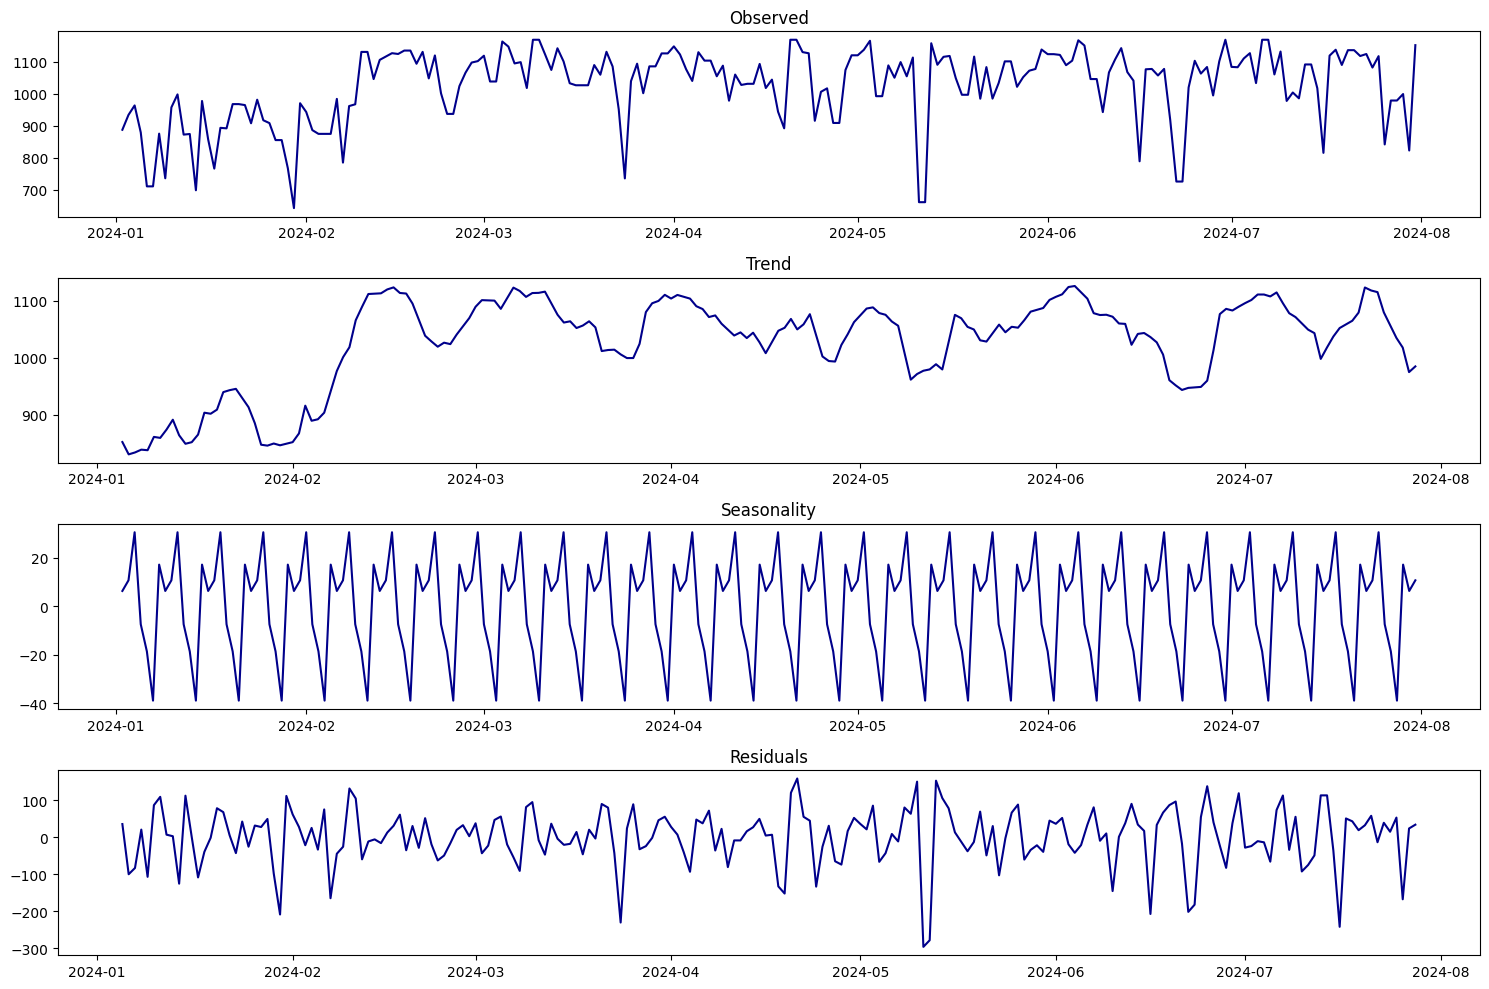

In [43]:
# Analyze time series by decomposing seasonality
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series into trend, seasonality, and residuals
decomposition = seasonal_decompose(data, model='additive', period=7)

# Plot the decomposition
plt.figure(figsize=(15, 10))

plt.subplot(4, 1, 1)
plt.plot(decomposition.observed, color='darkblue')
plt.title('Observed')

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, color='darkblue')
plt.title('Trend')

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, color='darkblue')
plt.title('Seasonality')

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, color='darkblue')
plt.title('Residuals')

plt.tight_layout()

# Save the plot
plt.savefig('data/output/price_time_series_decomposition.png')

# Show the plot
plt.show()


# Modeling

In [45]:
type(data)

pandas.core.series.Series

In [46]:
# Load the time series data
daily_data = data.copy()

# Split into train and test sets (80% train, 20% test)
train_size = int(len(daily_data) * 0.8)
train, test = daily_data.iloc[:train_size], daily_data.iloc[train_size:]

# Model parameters
window_size = 30  # Known seasonality: 30 days
refit_interval = 15  # Increase training set size by 15 days on each refitting

# Function to calculate degradation metric
def degradation_metric(actual, predicted, threshold=0.05):
    within_threshold = np.abs((actual - predicted) / actual) <= threshold
    return within_threshold.sum()

# Store backtesting results
bayesian_results = []
execution_times = []

# Backtesting with refitting, increasing training size by 15 days
for start in range(0, len(test), refit_interval):
    # Define training and testing windows
    train_end = train_size + start
    test_end = min(train_size + start + refit_interval, len(daily_data))
    train_window = daily_data.iloc[:train_end]
    test_window = daily_data.iloc[train_end:test_end]
    
    # Measure execution time
    start_time = time.time()
    
    # Define prior distribution (historical data)
    prior_mean = train_window.mean()
    prior_std = train_window.std()
    
    # Define likelihood (last 30 days of data)
    recent_data = train_window[-window_size:]  # Take last 30 days to reflect seasonality
    likelihood_mean = recent_data.mean()
    likelihood_std = recent_data.std()
    
    # Calculate posterior distribution
    posterior_var = 1 / ((1 / prior_std**2) + (1 / likelihood_std**2))
    posterior_mean = posterior_var * ((prior_mean / prior_std**2) + (likelihood_mean / likelihood_std**2))
    posterior_std = posterior_var**0.5
    
    # Perform predictions for the test window
    forecast = norm.rvs(loc=posterior_mean, scale=posterior_std, size=len(test_window))
    execution_time = time.time() - start_time
    
    # Calculate metrics
    mape = mean_absolute_percentage_error(test_window, forecast)
    degradation = degradation_metric(test_window, forecast)
    
    # Store results
    bayesian_results.append({
        'Refit Value': len(train_window),
        'Execution Time (s)': execution_time,
        'MAPE': mape,
        'Degradation Metric': degradation
    })
    execution_times.append(execution_time)

# Convert results to a DataFrame
bayesian_results_df = pd.DataFrame(bayesian_results)

# Save the results to a csv file
bayesian_results_df.to_csv('data/output/bayesian_results.csv', index=False)

# Display the results
print(bayesian_results_df)

# Summary of average metrics
average_metrics = bayesian_results_df.mean()

# Save the average metrics to a csv file
average_metrics.to_csv('data/output/average_metrics.csv')

# Display the average metrics
print(average_metrics)

   Refit Value  Execution Time (s)      MAPE  Degradation Metric
0          169            0.000863  0.111929                   7
1          184            0.000565  0.070866                   8
2          199            0.000401  0.080191                   5
Refit Value           184.000000
Execution Time (s)      0.000610
MAPE                    0.087662
Degradation Metric      6.666667
dtype: float64


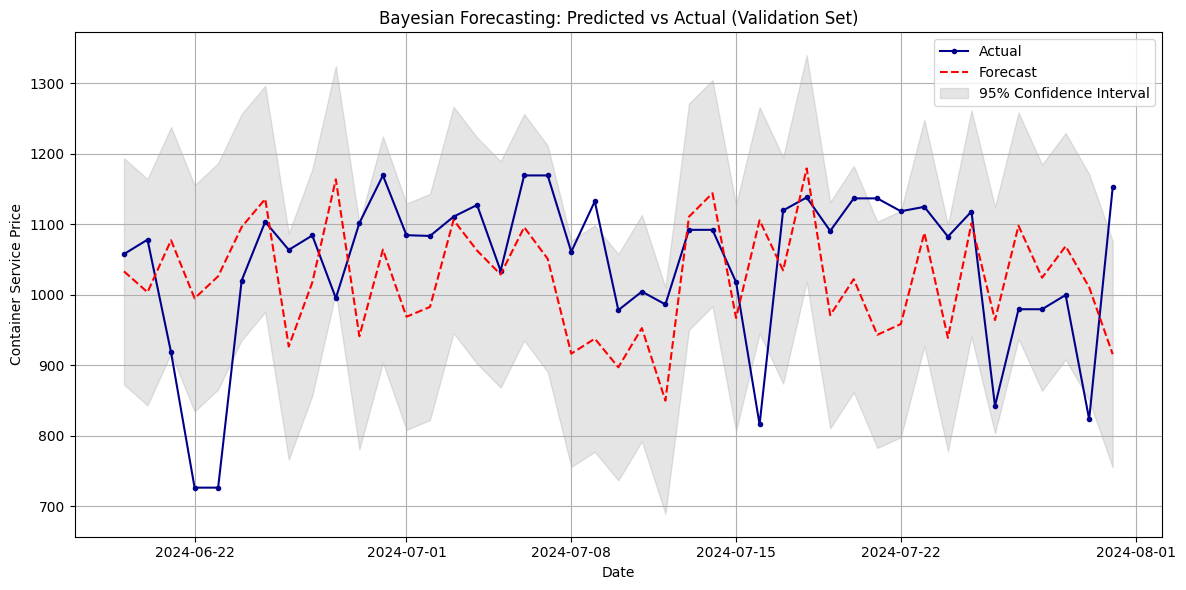

In [47]:

# Perform predictions on the test set using the posterior distribution
forecast = norm.rvs(loc=posterior_mean, scale=posterior_std, size=len(test))

# Plot the predicted series against the actual values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual', color='darkblue', marker='.')
plt.plot(test.index, forecast, label='Forecast', color='red', linestyle='--')
plt.fill_between(test.index, 
                 forecast - 1.96 * posterior_std, 
                 forecast + 1.96 * posterior_std, 
                 color='gray', alpha=0.2, label='95% Confidence Interval')

# Titles and labels
plt.title("Bayesian Forecasting: Predicted vs Actual (Validation Set)")
plt.xlabel("Date")
plt.ylabel("Container Service Price")

# Other settings for the plot
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot in the output directory
plt.savefig('data/output/bayesian_forecast.png')

# Display the plot
plt.show()

In [48]:
import matplotlib.pyplot as plt

# Plotting the Degradation Metric for each iteration of backtesting
degradation_values = bayesian_results_df['Degradation Metric']

# Plotting the degradation metric over time (for each iteration)
plt.figure(figsize=(10, 6))
plt.plot(degradation_values, marker='.', linestyle='-', color='b')

# Title and labels
plt.title("Degradation Metric Over Time (Backtesting Iterations)")
plt.xlabel("Iteration (Training Window Expansion)")
plt.ylabel("Degradation Metric (Number of Days Within Threshold)")

# Other settings for the plot
plt.grid(True)
plt.tight_layout()

# Save the plot in the output directory
plt.savefig('data/output/bayesian_degradation_metric.png')

# Display the plot
plt.show()


### Neural Network approach

In [49]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Suppress TensorFlow warnings
tf.get_logger().setLevel('ERROR')

# Define the model
model = Sequential()

# Input layer and first hidden layer
model.add(Dense(64, input_dim=30, activation='relu'))  # input_dim=30, assuming 30 days as input

# hidden layers
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))

# Output layer 
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,625 (72.75 KB)

 Trainable params: 18,625 (72.75 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
import tensorflow as tf

# Function to split the time series into training and testing windows
def create_windowed_dataset(data, window_size, train_size):
    X_train, y_train, X_test, y_test = [], [], [], []
    
    # Training data (windows for X_train and y_train)
    for i in range(train_size - window_size):
        X_train.append(data[i:i + window_size])
        y_train.append(data[i + window_size])
    
    # Testing data (windows for X_test and y_test)
    for i in range(train_size, len(data) - window_size):
        X_test.append(data[i:i + window_size])
        y_test.append(data[i + window_size])
    
    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

# Create the training and testing datasets (e.g., using the first 70% for training)
window_size = 30
train_size = int(len(data) * 0.7)  # Use 70% of the data for training
X_train, y_train, X_test, y_test = create_windowed_dataset(data, window_size, train_size)

# Convert to TensorFlow tensors
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)

# Create the training dataset
batch_size = 32
dataset_train = tf.data.Dataset.from_tensor_slices((X_train_tensor, y_train_tensor))
dataset_train = dataset_train.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Train the model
history = model.fit(dataset_train, epochs=50, verbose=1)

# Make predictions on the test data
predictions = model.predict(X_test_tensor)

# Evaluate metrics: MAPE and Degradation Metric
# MAPE
mape = mean_absolute_percentage_error(y_test, predictions)
print(f"MAPE: {mape * 100:.2f}%")

# Degradation Metric (based on performance over time)
initial_mape = mean_absolute_percentage_error(y_test[:10], predictions[:10])  # First predictions
final_mape = mean_absolute_percentage_error(y_test[-10:], predictions[-10:])  # Last predictions
degradation_metric = (final_mape - initial_mape) * 100  # Change in percentage
print(f"Degradation Metric: {degradation_metric:.2f}%")

# Plot the original series and predictions
plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label='Original Time Series', color='darkblue', marker='.', alpha=0.5)

# plot the predictions
plt.plot(data.index[train_size + window_size:], predictions, label='Predictions', color='red', linestyle='dashed')

# Titles and labels
plt.title('Neural Network Forecasting: Predicted vs Actual (Validation Set)')
plt.xlabel('Day')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Save the plot in output folder
plt.savefig('data/output/nn_forecast.png')

# Show the plot
plt.show()


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 794176.6250   
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34781.2188
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 107926.3828
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23217.5762
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 23276.6211
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 36627.9141
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12883.7207
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17704.6797
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 18656.3750 
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 11819.6123 
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11658.1416
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10172.0361
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9616.3936
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12774.0508
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - 